In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, classification_report

In [22]:
df = pd.read_csv('../data/full-corpus.csv')

In [19]:
df.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 5 columns):
Topic        5113 non-null object
Sentiment    5113 non-null object
TweetId      5113 non-null int64
TweetDate    5113 non-null object
TweetText    5113 non-null object
dtypes: int64(1), object(4)
memory usage: 199.8+ KB


In [21]:
y = df.pop('Sentiment')
y.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: Sentiment, dtype: object

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [110]:
train_text = X_train['TweetText'].to_numpy()
test_text = X_test['TweetText'].to_numpy()

In [111]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_text)
tfidf_transformer = TfidfTransformer()

In [112]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [113]:
y_pred = clf.predict(count_vect.transform(test_text))
# print(average_precision_score(y_test, y_pred))
accuracy_score(y_test, y_pred)

0.6802189210320563

The accuracy is pretty good but it is only predicting neutral. Need to balance the dataframe.

## This is how you should be doing predict in your flask app

In [11]:
test_pred = clf.predict(count_vect.transform(["I HATE my new Iphone!!!!"]))
str(test_pred[0])

'neutral'

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[288   0 132   0]
 [  0   3 149   0]
 [  7   0 579   0]
 [  0   0 121   0]]


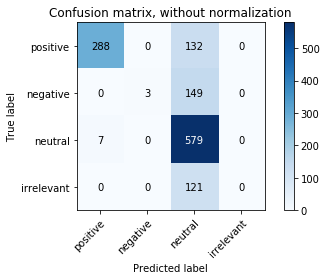

In [13]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['positive', 'negative', 'neutral', 'irrelevant'],
                      title='Confusion matrix, without normalization')
plt.show()

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[288,   0, 132,   0],
       [  0,   3, 149,   0],
       [  7,   0, 579,   0],
       [  0,   0, 121,   0]])

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  irrelevant       0.98      0.69      0.81       420
    negative       1.00      0.02      0.04       152
     neutral       0.59      0.99      0.74       586
    positive       0.00      0.00      0.00       121

    accuracy                           0.68      1279
   macro avg       0.64      0.42      0.40      1279
weighted avg       0.71      0.68      0.61      1279



/home/jarid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
print(y_pred)

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [17]:
len(y_pred)

1279

In [18]:
len(y_test)

1279

## Perform undersampling to balance sentiment classes

In [24]:
def get_sentiment_df(df):
    pos_df = df[df['Sentiment'] == 'positive']
    neg_df = df[df['Sentiment'] == 'negative']
    neutral_df = df[df['Sentiment'] == 'neutral']
    irr_df = df[df['Sentiment'] == 'irrelevant']
    return pos_df, neg_df, neutral_df, irr_df

In [25]:
pos_df, neg_df, neutral_df, irr_df = get_sentiment_df(df)

In [26]:
print(f'Num Positive: {len(pos_df)}')
print(f'Num Negative: {len(neg_df)}')
print(f'Num neutral: {len(neutral_df)}')
print(f'Num irrelevant: {len(irr_df)}')

Num Positive: 519
Num Negative: 572
Num neutral: 2333
Num irrelevant: 1689


In [27]:
# Downsample negative class to match positive class
df_neg_down = resample(neg_df,
                    replace=False,    # sample without replacement
                    n_samples=len(pos_df),     # to match minority class
                    random_state=42) # reproducible results
len(df_neg_down)

519

In [28]:
# Downsample negative class to match positive class
df_neutral_down = resample(neutral_df,
                    replace=False,    # sample without replacement
                    n_samples=len(pos_df),     # to match minority class
                    random_state=42) # reproducible results
len(df_neutral_down)

519

In [29]:
# Downsample negative class to match positive class
df_irr_down = resample(irr_df,
                    replace=False,    # sample without replacement
                    n_samples=len(pos_df),     # to match minority class
                    random_state=42) # reproducible results
len(df_irr_down)

519

In [30]:
df_balanced = pd.concat([pos_df, df_neg_down, df_neutral_down, df_irr_down])

## Performing Sentiment Classification on Balanced Dataset

In [31]:
y = df_balanced.pop('Sentiment')
y.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: Sentiment, dtype: object

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced, y, random_state=42)

In [33]:
train_text = X_train['TweetText'].to_numpy()
test_text = X_test['TweetText'].to_numpy()

In [34]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_text)
X_test_counts = count_vect.fit_transform(test_text)
tfidf_transformer = TfidfTransformer()

In [37]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
y_pred = clf.predict(count_vect.transform(test_text))
# print(average_precision_score(y_test, y_pred))
# accuracy_score(y_test, y_pred)

ValueError: dimension mismatch

In [64]:
count_vect_test.fit(neg_df['TweetText'].to_numpy())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [65]:
ind_max = clf.feature_log_prob_.argsort()[::-1]
ind_max

array([[3137, 3878, 3877, ...,  457, 5257, 2248],
       [   0, 3808, 3807, ..., 5475, 1071, 2497],
       [   0, 3849, 3848, ..., 5351, 5257,  457],
       [   0, 3557, 3558, ..., 2497, 5475, 1357]])

In [66]:
ind_top = ind_max[:,:100]
ind_top.shape

(4, 100)

In [67]:
feature_names = np.array(count_vect.get_feature_names())
feature_names.shape

(2414,)

In [68]:
feature_names_neg = feature_names[ind_top[0]]
feature_names_neg

IndexError: index 3137 is out of bounds for axis 0 with size 2414